In [1]:
import jupyter

In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox

from src.utils.system import boot
from src.defaults import RANDOM_SEEDS, TOP2_STOCK_BY_SECTOR
from tracker import OHLCV_DF, EpisodeTracker, EnvironmentTracker, AgentTracker



C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Configuration ======================
excluded_tickers = sorted(['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV'])

config = {
    "regressor": "RandomForestRegressor",
    "n_estimators": 300,
    "random_state": 314,
    "transaction_cost": 0
}

run_settings = {
    "excluded_tickers": excluded_tickers,
    "min_samples": 10,
    "cv_folds": 3,
    "lags": 5,
    "start_date": "2023-12-31",
    "end_date": "2025-05-01",
    "seed": 314,
    "episode_length": 50,
    "noise_feature_cols": ["return_1d", "volume"],
    "train_steps": 10_000,
    "lookback": 0,
    
}

# System Boot =======================
DEVICE = boot()



In [4]:
# Load and Prepare Data ================
ohlcv_df = OHLCV_DF.copy()
ohlcv_df['month'] = ohlcv_df['date'].dt.to_period('M')
ohlcv_df['return_1d'] = ohlcv_df['return_1d'].fillna(0)
ohlcv_df['sector_id'] = ohlcv_df['sector_id'].fillna('unknown')
ohlcv_df['industry_id'] = ohlcv_df['industry_id'].fillna('unknown')

# Filter Tickers ======================
tickers = ohlcv_df['symbol'].unique()
tickers = tickers[~np.isin(tickers, excluded_tickers)]
tickers = ["AAPL"]  # Force test with AAPL
#tickers = TOP2_STOCK_BY_SECTOR
# Load and prepare trackers
ep_tracker    = EpisodeTracker()
env_tracker   = EnvironmentTracker()
agent_tracker = AgentTracker()

In [5]:
def add_lags(df,lags):
   
    df_lag = df.copy()
    for lag in range(1, lags + 1):
     
        df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
        df_lag[f'volume_lag_{lag}'] = df_lag['volume_change'].shift(lag)
        df_lag[f'market_return_lag_{lag}'] = df_lag['market_return_1d'].shift(lag)
   
    #df_lag = df_lag.dropna()
    #print(df_lag)
    return df_lag


In [6]:
def residual_based_predictability_label(df_lag, run_settings):
    """
    Estimate predictability (cv_r2) using residuals from RandomForestRegressor.
    Supports sub-episode curriculum-style partitions.
    """
    required_cols = (
        [f'return_lag_{i}' for i in range(1, run_settings['lags'] + 1)] +
        [f'volume_lag_{i}' for i in range(1, run_settings['lags'] + 1)] +
        [f'market_return_lag_{i}' for i in range(1, run_settings['lags'] + 1)]
    )

    df_lag = df_lag.dropna(subset=required_cols + ['return_1d'])

    if len(df_lag) < run_settings["min_samples"]:
        return np.nan  # Not enough data

    X = df_lag[required_cols].values
    y = df_lag['return_1d'].values

    splits = [1/3, 2/3, 1.0]
    cv_r2s = []

    for split in splits:
        split_len = int(len(X) * split)
        if split_len < run_settings["min_samples"]:
            continue  # Avoid underfitting
        X_split = X[:split_len]
        y_split = y[:split_len]

        model = RandomForestRegressor(
            n_estimators=config['n_estimators'],
            random_state=config['random_state']
        )
        model.fit(X_split, y_split)
        r2 = np.mean(cross_val_score(model, X_split, y_split, cv=run_settings["cv_folds"], scoring='r2'))
        cv_r2s.append(r2)

    # You could return just the final r² or an average across splits
    final_r2 = np.mean(cv_r2s) if cv_r2s else np.nan
    return final_r2


In [7]:
# Feature Extraction Loop ====================
features, targets, metadata = [], [], []
def central_tendency_difference (mean,median):
    return abs(mean-median)/(abs(mean+median)/2)

for symbol in tqdm(tickers):
    df = ohlcv_df[ohlcv_df['symbol'] == symbol].sort_values('date').copy()
    df = df[df['date'] > run_settings['start_date']]
    df = df.iloc[:-run_settings["episode_length"]]
    months = df['month'].unique()
    # t stands for time
    # t1_ stands for time+1
    for i in range(len(months)):
        try:
            
            target_date = str(months[i])+'-01' 
            episodes = ep_tracker.findEpisode(
                target_date,
                symbol,
                episode_length=run_settings['episode_length'],
                lookback=run_settings['lookback'],
                mode='both')
            
            df_t0 = episodes['train']['df']
            df_t0 = add_lags(df_t0,run_settings["lags"])
            df_t0 = df_t0.iloc[episodes['train']['df_start_iloc']:]
            df_t1 = episodes['test']['df']
            df_t1 = add_lags(df_t1,run_settings["lags"])
        
            df_t1 = df_t1.iloc[episodes['test']['df_start_iloc']:]
          
            r1d = df_t0['return_1d'].astype(float).values
            v   = df_t0['volume_change'].astype(float).values
       
            feat = {
                'symbol': symbol,
                'target_date': target_date,
                'episode_id': episodes['train']['episode_id'],
                'next_episode_id': episodes['test']['episode_id'],
                #'month_str': str(m_t),
                
                'r1d_mean': np.mean(r1d),
                'r1d_median':np.median(r1d),
                'r1d_std': np.std(r1d),
                'r1d_ctm_diff': central_tendency_difference(np.mean(r1d),np.median(r1d)),
                'r1d_skew': skew(r1d),
                'r1d_kurtosis': kurtosis(r1d),
                'r1d_entropy': entropy(np.histogram(r1d, bins=10, density=True)[0] + 1e-8),
                
                'v1d_mean': np.mean(v),
                'v1d_median':np.median(v),
                'v1d_std': np.std(v),
                'v1d_ctm_diff': central_tendency_difference(np.mean(v),np.median(v)),
                'v1d_skew': skew(v),
                'v1d_kurtosis': kurtosis(v),
                'v1d_entropy': entropy(np.histogram(v, bins=10, density=True)[0] + 1e-8),
            }
            
            cv_r2 = residual_based_predictability_label(df_t1, run_settings)
            print('cv',cv_r2)
            if cv_r2 is None:
                continue  # skip if label couldn't be computed

            features.append(feat)
            targets.append(cv_r2)
            metadata.append({
                "symbol": symbol,
                "target_date": target_date,
                "train_episode_id": episodes['train']['episode_id'],
                "test_episode_id": episodes['test']['episode_id']
            })

        except Exception as e:
            print(f"Skipping {symbol} {months[i]} due to error: {e}")
        except :
            print(months[i])
            


  0%|          | 0/1 [00:00<?, ?it/s]

cv -0.487182152831845
cv -0.862697402174927
cv -0.3703361007684695
cv -0.5245104572918781
cv -0.4595661218398064
cv -1.2694711961593261
cv -1.3578187158284336
cv -1.323281024665671
cv -0.6033362968009569
cv -0.415038400766567
cv -0.4884171163617524
cv -1.1755689485905938
cv -0.5507749794672885
cv -1.5651485177786648


100%|██████████| 1/1 [01:16<00:00, 76.91s/it]

cv -0.8128166327754655


In [8]:
# VISUAÇ INSPECTION =====================

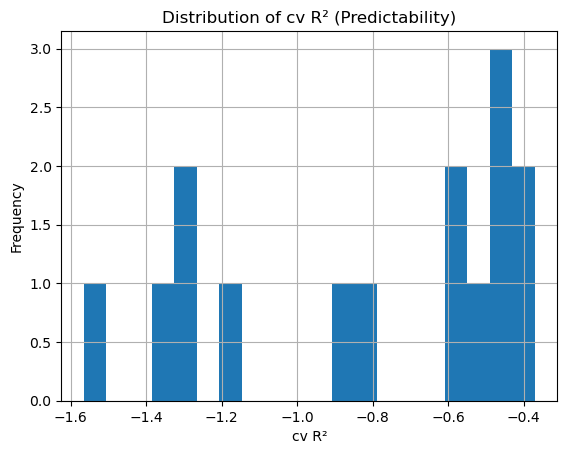

In [9]:
import pandas as pd

X_df = pd.DataFrame(features)
y_df = pd.Series(targets, name="cv_r2")
meta_df = pd.DataFrame(metadata)
full_df = pd.concat([X_df, y_df, meta_df], axis=1)

import matplotlib.pyplot as plt

plt.hist(y_df, bins=20)
plt.title("Distribution of cv R² (Predictability)")
plt.xlabel("cv R²")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [12]:
print(full_df['cv_r2'].describe())
print(full_df['cv_r2'].head(10))

count       0
unique      0
top       NaN
freq      NaN
Name: cv_r2, dtype: object
Series([], Name: cv_r2, dtype: object)


In [ ]:
"""
et me know which path you want to take next — or if you'd like to pause here and add more features
(e.g., change-points, GARCH, Fourier stats, etc.) 

"""